In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as pickle

### Data Loading

In [4]:
df_original = pd.read_csv('/content/drive/Shareddrives/CIS519/tindetheus_datasets/TinderFullDataBase/user_database.csv')

In [5]:
len(df_original)

71620

In [6]:
df = pd.read_csv('/content/drive/Shareddrives/CIS519/tindetheus_datasets/TinderFullDataBase/user_database.csv')

In [7]:
df.head()

,Unnamed: 0,Name,Age,Bio,Distance (km),Jobs,Schools,Photos,UserID,Did I like?
0,0,Meranda,23,"I like to chillll, have a 6 year old boy.😎⭐️🌈☀...",90.12304,[],[],['http://images.gotinder.com/546d5087345cb5871...,546d5087345cb58717cc870f,Like
1,1,Bianca,20,Real Hasta la Muerte ',99.77908,[],[],['http://images.gotinder.com/579f65962244be772...,579f65962244be772f62d505,Dislike
2,2,Rhiannon,20,Maybe I can find someone to travel the world w...,91.73238,[],[],['http://images.gotinder.com/55f79de20fad75245...,55f79de20fad752454f86526,Dislike
3,3,Nicole,22,I'm a Whovian social historian who loves start...,101.38842,['Flagler Beach Ocean Lifeguard'],"['University of North Florida', 'Leeds Beckett...",['http://images.gotinder.com/55973ff9c3975d232...,55973ff9c3975d232dae5dce,Like
4,4,Heather,27,NaN,88.5137,[],['CTAE'],['http://images.gotinder.com/57c73759b8678df11...,57c73759b8678df11426c457,Dislike


###**Data Cleaning**

In [8]:
df.drop(columns=['Unnamed: 0','Photos'], inplace=True)

In [9]:
df['Jobs'] = df['Jobs'].str.strip('[]').str.strip(' ')
df['Schools'] = df['Schools'].str.strip('[]').str.strip()

In [10]:
df['UserID'].nunique()

8540

In [11]:
df.head()

,Name,Age,Bio,Distance (km),Jobs,Schools,UserID,Did I like?
0,Meranda,23,"I like to chillll, have a 6 year old boy.😎⭐️🌈☀...",90.12304,,,546d5087345cb58717cc870f,Like
1,Bianca,20,Real Hasta la Muerte ',99.77908,,,579f65962244be772f62d505,Dislike
2,Rhiannon,20,Maybe I can find someone to travel the world w...,91.73238,,,55f79de20fad752454f86526,Dislike
3,Nicole,22,I'm a Whovian social historian who loves start...,101.38842,'Flagler Beach Ocean Lifeguard',"'University of North Florida', 'Leeds Beckett ...",55973ff9c3975d232dae5dce,Like
4,Heather,27,NaN,88.5137,,'CTAE',57c73759b8678df11426c457,Dislike


In [12]:
df = df.drop_duplicates()

In [13]:
df.head()

,Name,Age,Bio,Distance (km),Jobs,Schools,UserID,Did I like?
0,Meranda,23,"I like to chillll, have a 6 year old boy.😎⭐️🌈☀...",90.12304,,,546d5087345cb58717cc870f,Like
1,Bianca,20,Real Hasta la Muerte ',99.77908,,,579f65962244be772f62d505,Dislike
2,Rhiannon,20,Maybe I can find someone to travel the world w...,91.73238,,,55f79de20fad752454f86526,Dislike
3,Nicole,22,I'm a Whovian social historian who loves start...,101.38842,'Flagler Beach Ocean Lifeguard',"'University of North Florida', 'Leeds Beckett ...",55973ff9c3975d232dae5dce,Like
4,Heather,27,NaN,88.5137,,'CTAE',57c73759b8678df11426c457,Dislike


In [14]:
import numpy as np
df=df.replace(r'', np.nan, regex=True)

In [15]:
df.isna().sum()

Name                1
Age                 1
Bio              2487
Distance (km)       6
Jobs             5313
Schools          3409
UserID             11
Did I like?        74
dtype: int64

In [16]:
df = df.loc[df['Did I like?'].isna()==False,:]
df = df.loc[df['Name'].isna()==False,:]
df = df.loc[df['UserID'].isna()==False,:]

In [17]:
df.head()

,Name,Age,Bio,Distance (km),Jobs,Schools,UserID,Did I like?
0,Meranda,23,"I like to chillll, have a 6 year old boy.😎⭐️🌈☀...",90.12304,NaN,NaN,546d5087345cb58717cc870f,Like
1,Bianca,20,Real Hasta la Muerte ',99.77908,NaN,NaN,579f65962244be772f62d505,Dislike
2,Rhiannon,20,Maybe I can find someone to travel the world w...,91.73238,NaN,NaN,55f79de20fad752454f86526,Dislike
3,Nicole,22,I'm a Whovian social historian who loves start...,101.38842,'Flagler Beach Ocean Lifeguard',"'University of North Florida', 'Leeds Beckett ...",55973ff9c3975d232dae5dce,Like
4,Heather,27,NaN,88.5137,NaN,'CTAE',57c73759b8678df11426c457,Dislike


In [18]:
len(df)

8477

In [19]:
df.drop(columns=['Name'], inplace=True)

In [20]:
df.head()

,Age,Bio,Distance (km),Jobs,Schools,UserID,Did I like?
0,23,"I like to chillll, have a 6 year old boy.😎⭐️🌈☀...",90.12304,NaN,NaN,546d5087345cb58717cc870f,Like
1,20,Real Hasta la Muerte ',99.77908,NaN,NaN,579f65962244be772f62d505,Dislike
2,20,Maybe I can find someone to travel the world w...,91.73238,NaN,NaN,55f79de20fad752454f86526,Dislike
3,22,I'm a Whovian social historian who loves start...,101.38842,'Flagler Beach Ocean Lifeguard',"'University of North Florida', 'Leeds Beckett ...",55973ff9c3975d232dae5dce,Like
4,27,NaN,88.5137,NaN,'CTAE',57c73759b8678df11426c457,Dislike


In [21]:
df.loc[df["Jobs"].isna() == False,"Jobs"] = 1
df.loc[df["Schools"].isna() == False,"Schools"] = 1
df.loc[df["Jobs"].isna() != False,"Jobs"] = 0
df.loc[df["Schools"].isna() != False,"Schools"] = 0

In [22]:
df.head()

,Age,Bio,Distance (km),Jobs,Schools,UserID,Did I like?
0,23,"I like to chillll, have a 6 year old boy.😎⭐️🌈☀...",90.12304,0,0,546d5087345cb58717cc870f,Like
1,20,Real Hasta la Muerte ',99.77908,0,0,579f65962244be772f62d505,Dislike
2,20,Maybe I can find someone to travel the world w...,91.73238,0,0,55f79de20fad752454f86526,Dislike
3,22,I'm a Whovian social historian who loves start...,101.38842,1,1,55973ff9c3975d232dae5dce,Like
4,27,NaN,88.5137,0,1,57c73759b8678df11426c457,Dislike


In [23]:
len(df)

8477

# NLP part

In [24]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
import re


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [25]:
df = df.reset_index(drop= True)
df.loc[df['Bio'].isna() ==True, 'Bio'] = str('')
df

,Age,Bio,Distance (km),Jobs,Schools,UserID,Did I like?
0,23,"I like to chillll, have a 6 year old boy.😎⭐️🌈☀...",90.12304,0,0,546d5087345cb58717cc870f,Like
1,20,Real Hasta la Muerte ',99.77908,0,0,579f65962244be772f62d505,Dislike
2,20,Maybe I can find someone to travel the world w...,91.73238,0,0,55f79de20fad752454f86526,Dislike
3,22,I'm a Whovian social historian who loves start...,101.38842,1,1,55973ff9c3975d232dae5dce,Like
4,27,,88.5137,0,1,57c73759b8678df11426c457,Dislike
...,...,...,...,...,...,...,...
8472,27,"*Hurricane hit my beach town, come grab a drin...",8.0467,1,1,5792e3a8eca44e9a2cbd3096,Dislike
8473,23,"Born and raised in Nashville, TN. \nVirginia T...",4.82802,0,0,5349e4be440f48275f0007f9,Dislike
8474,24,🔮♏️(Scorpio) 🇺🇸(American) 🇦🇷(Argentinean) 🇮🇹(I...,3.21868,0,0,55e878b0133c0fc12e00841f,Dislike
8475,31,"Vegan adventurer.\n\nAttracted to kindness, in...",6.43736,1,1,57334154fc9cd2a6238dabd5,Dislike


## **CountVectorizer and Cluster method**

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

def preprocess_text(text):
  text = text.lower()
  text = re.sub(r'\d+', '', text)
  return text

# Instantiating the Vectorizer, experimenting with both
vectorizer = CountVectorizer(min_df = 3, preprocessor= preprocess_text)
#vectorizer = TfidfVectorizer()

# Fitting the vectorizer to the Bios
x = vectorizer.fit_transform(df['Bio'])

# Creating a new DF that contains the vectorized words
df_wrds = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names())

# Concating the words DF with the original DF
new_df = pd.concat([df, df_wrds], axis=1)
label = new_df['Did I like?']
user_id = new_df['UserID']

sw_lowfreq = list(vectorizer.stop_words_)     ## stored for the Word2Vec method

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [27]:
print(len(sw_lowfreq))
df_wrds
# df_wrds.to_csv('nlp1.cvs', index = False) 

7706


,aa,ability,able,about,above,abs,absolute,absolutely,absorbed,academy,accent,accept,acceptable,accepting,accident,according,account,accountant,accounting,across,act,acting,action,active,actively,activism,activist,activities,activity,actress,actual,actually,add,addict,addicted,addiction,adding,admin,administration,admit,...,xo,ya,yankees,yea,yeah,year,years,yellow,yep,yes,yesterday,yet,yo,yoga,yogi,yogurt,york,yorker,you,young,younger,your,youre,yours,yourself,youtube,yr,yrs,yummy,zealand,zeppelin,zero,zoe,zombie,zone,zoo,zookeeper,zoology,zumba,καθ
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8472,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8473,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8474,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8475,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Reduce the dimensionality by applying PCA**

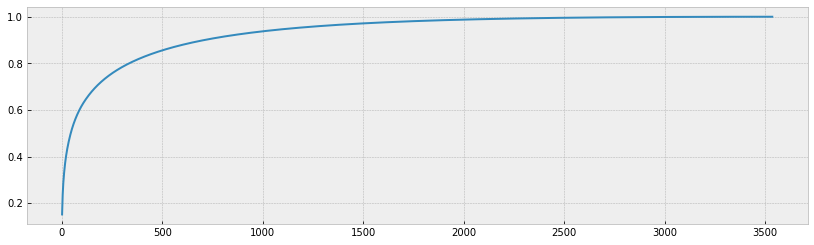

Number features: 1142
Total Variance Explained: 0.9500553261132394
[0.15135728 0.18472529 0.21276404 ... 0.94896207 0.94903156 0.94910079]


In [28]:
# Importing the library
from sklearn.decomposition import PCA

# Instantiating PCA
pca = PCA()

# Fitting and Transforming the DF
df_pca = pca.fit_transform(df_wrds)

# Plotting to determine how many features should the dataset be reduced to
plt.style.use("bmh")
plt.figure(figsize=(14,4))
plt.plot(range(1,df_wrds.shape[1]+1), pca.explained_variance_ratio_.cumsum())
plt.show()

# Finding the exact number of features that explain at least 95% of the variance in the dataset
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance>=.95])
n_to_reach_95 = df_wrds.shape[1] - n_over_95

# Printing out the number of features needed to retain 95% variance
print(f"Number features: {n_to_reach_95}\nTotal Variance Explained: {total_explained_variance[n_to_reach_95]}")

# Reducing the dataset to the number of features determined before
pca = PCA(n_components=n_to_reach_95)

# Fitting and transforming the dataset to the stated number of features and creating a new DF
df_pca = pca.fit_transform(df_wrds)

# Seeing the variance ratio that still remains after the dataset has been reduced
print(pca.explained_variance_ratio_.cumsum())




In [29]:
df_pca_ = pd.DataFrame(df_pca)
df_pca_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141
0,-0.428464,0.348804,-0.657371,-0.054228,0.039091,-0.373249,-0.291272,-0.267245,0.243326,0.136338,0.009656,0.351103,0.346967,-0.758343,0.165708,-0.514263,0.422071,-0.257374,-0.071528,-0.066590,0.307006,-0.109578,0.067776,-0.127652,-0.122630,0.011618,0.147241,-0.065111,-0.104390,0.024366,0.192180,-0.123899,0.045520,0.028250,-0.111232,-0.099901,0.063048,0.075743,0.037899,-0.007196,...,-0.017972,0.017380,-0.025909,-0.014518,-0.000768,0.017881,0.012523,0.007195,-0.010067,0.008294,-0.003746,0.011425,0.021667,0.006644,-0.017062,0.001178,-0.012462,0.006509,0.009615,0.017791,-0.021215,6.915062e-03,-0.004238,-0.010705,0.005015,0.006455,0.012186,-0.012003,0.002787,0.033029,-0.001921,0.013843,0.021912,-0.038949,-0.004382,-0.009650,0.004476,-0.003363,0.003843,0.000132
1,-1.139973,-0.018788,-0.051720,-0.028079,0.009687,-0.024782,-0.020905,-0.019885,0.001143,-0.024200,0.042518,0.005344,-0.053239,-0.018932,-0.034646,-0.006883,-0.020358,-0.003144,-0.008683,0.011795,0.008045,0.023545,0.003209,-0.031839,0.008995,0.018139,-0.009654,-0.005331,0.000723,-0.016271,0.010310,-0.005680,-0.004794,-0.026113,-0.026165,0.014059,-0.047498,-0.005557,-0.011910,-0.001858,...,0.005387,-0.036169,0.017604,-0.052156,-0.001619,0.005790,0.000465,0.024463,-0.021127,-0.001658,0.002651,-0.009458,0.012137,-0.008170,0.006250,-0.003094,-0.002930,-0.012704,-0.006398,0.003260,0.007133,2.432340e-02,0.013089,-0.008619,0.011268,0.031047,0.013849,-0.003186,0.026485,-0.026652,0.005256,0.000519,-0.001129,0.010900,-0.038423,-0.018864,-0.011227,0.008484,0.016732,-0.001606
2,3.300553,0.575785,-1.911684,-0.370081,1.031075,-0.788102,-0.695145,0.889621,-0.049000,0.365225,0.066169,1.519855,0.401058,-1.394849,0.481630,-0.273475,0.047703,-0.128940,0.160625,0.587248,-0.002213,-0.556332,-0.511423,-0.679053,-0.146906,0.520505,1.175172,-0.831727,0.022927,0.809068,-0.541266,-0.029577,0.190877,-0.886568,0.416975,-0.035131,-0.020837,-0.041936,-0.373081,0.450660,...,0.057132,0.047517,0.026021,-0.054857,-0.021498,-0.033621,0.049824,-0.080768,-0.025864,0.011485,0.048514,0.046103,0.021519,0.069044,0.067089,-0.036303,0.022606,0.071030,-0.093345,-0.010786,-0.011955,-6.631590e-02,-0.049997,-0.037403,0.023637,0.014899,-0.031281,0.027249,-0.007638,0.009256,-0.043930,-0.018883,-0.065792,-0.118292,-0.047440,-0.077568,-0.025254,0.014141,0.010940,-0.062419
3,1.063533,0.159902,0.024012,-0.171204,0.820677,-0.027955,0.641525,-0.411507,-0.196024,-0.246845,-0.304779,-0.067020,0.528402,0.697315,-0.220626,-0.120681,0.166865,0.141325,0.652463,-0.468344,-0.096560,-0.799741,0.323751,-0.229275,0.081058,0.148513,-0.207115,0.046986,0.379853,0.330260,-0.644672,1.292194,0.709279,0.158789,0.099109,-0.710996,-0.867133,0.592239,0.278803,-0.697869,...,0.116505,-0.032815,-0.062203,0.021655,-0.073248,-0.052176,-0.056492,0.094276,-0.000845,-0.046344,-0.066533,-0.059122,0.095142,0.003985,0.015726,0.044027,0.044532,0.027156,0.033775,-0.100081,-0.100532,-2.778898e-02,-0.062399,0.160823,0.039055,-0.015357,0.101188,-0.082896,0.064560,0.077219,-0.014183,-0.045960,-0.088887,-0.013788,0.013679,0.038503,-0.067080,-0.039977,-0.021506,0.080273
4,-1.150157,-0.022589,-0.054932,-0.032704,0.015841,-0.022874,-0.017645,-0.025313,-0.006466,-0.023444,0.027000,0.005663,-0.038242,-0.019253,-0.022439,-0.011419,-0.009258,-0.007112,-0.004476,-0.001548,0.006609,0.036772,0.008951,-0.014704,-0.002739,0.003391,-0.004810,-0.014948,-0.002958,-0.014663,-0.001655,-0.006004,-0.019551,-0.018963,0.003822,0.017932,-0.005167,0.005189,0.000310,-0.000815,...,0.000501,-0.000571,-0.000436,0.000513,-0.000054,0.000033,0.000033,0.000822,0.000234,0.000367,-0.000373,0.000785,-0.000423,0.000644,0.000449,0.000182,-0.000380,-0.000197,0.000795,0.000979,0.000508,8.359253

In [30]:
df_new_pca = pd.concat([df, df_pca_], axis =1)
df_new_pca = df_new_pca.drop(['Bio','Did I like?','Distance (km)'], axis =1)
df_new_pca = pd.concat([df_new_pca,label],axis=1)
print(df_new_pca)

     Age Jobs Schools  ...      1140      1141  Did I like?
0     23    0       0  ...  0.003843  0.000132         Like
1     20    0       0  ...  0.016732 -0.001606      Dislike
2     20    0       0  ...  0.010940 -0.062419      Dislike
3     22    1       1  ... -0.021506  0.080273         Like
4     27    0       1  ... -0.000181 -0.000095      Dislike
...   ..  ...     ...  ...       ...       ...          ...
8472  27    1       1  ...  0.056025  0.011076      Dislike
8473  23    0       0  ... -0.056142  0.035908      Dislike
8474  24    0       0  ...  0.035781 -0.027281      Dislike
8475  31    1       1  ... -0.119821  0.013038      Dislike
8476  18    0       1  ... -0.005624  0.018697      Dislike

[8477 rows x 1147 columns]


In [31]:
np.save('df_pca.npy', df_new_pca.to_numpy())
new_num_arr = np.load('df_pca.npy', allow_pickle=True)

In [32]:
new_num_arr

array([['23', 0, 0, ..., 0.0038427187675602347, 0.0001317867491326442,
        'Like'],
       ['20', 0, 0, ..., 0.01673174191137008, -0.0016057929376438902,
        'Dislike'],
       ['20', 0, 0, ..., 0.010940312105314643, -0.062418747682377554,
        'Dislike'],
       ...,
       ['24', 0, 0, ..., 0.035781418295210185, -0.027280875477109903,
        'Dislike'],
       ['31', 1, 1, ..., -0.11982056668426673, 0.01303785453569517,
        'Dislike'],
       ['18', 0, 1, ..., -0.005623665858370521, 0.01869744228459704,
        'Dislike']], dtype=object)

**Find the optimal # of clusters of applying KMean to cluster bio**

In [33]:
# Setting the amount of clusters to test out
cluster_cnt = [i for i in range(2, 20, 1)]

# Establishing empty lists to store the scores for the evaluation metrics
s_scores = []

db_scores = []

# Looping through different iterations for the number of clusters
for i in cluster_cnt:
    
    # # Hierarchical Agglomerative Clustering with different number of clusters
    # hac = AgglomerativeClustering(n_clusters=i)
    
    # hac.fit(df_pca)
    
    # cluster_assignments = hac.labels_
    
    # KMeans Clustering with different number of clusters
    k_means = KMeans(n_clusters=i)
    
    k_means.fit(df_pca)
    
    cluster_assignments = k_means.predict(df_pca)
    
    # Appending the scores to the empty lists    
    s_scores.append(silhouette_score(df_pca, cluster_assignments))
    
    db_scores.append(davies_bouldin_score(df_pca, cluster_assignments))

Max Value:
Cluster #    Cluster Score
2       0.454393

Min Value:
Cluster #     Cluster Score
17       0.241525


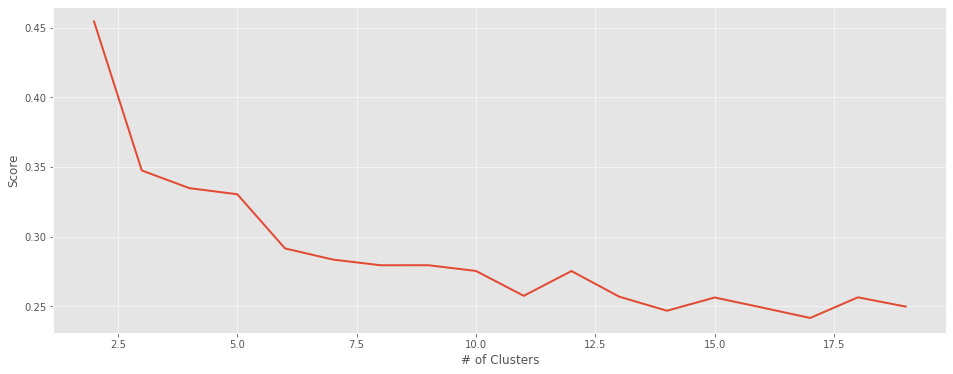

Max Value:
Cluster #     Cluster Score
16       4.431299

Min Value:
Cluster #    Cluster Score
2       2.516825


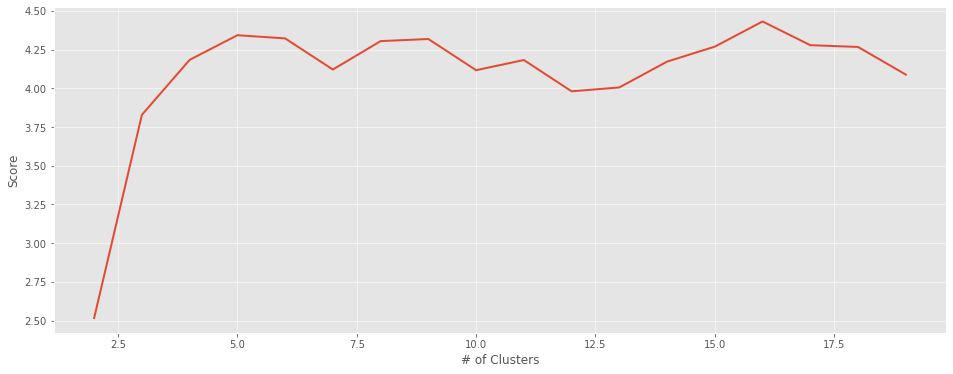

In [34]:
def plot_evaluation(y, x=cluster_cnt):
    """
    Plots the scores of a set evaluation metric. Prints out the max and min values of the evaluation scores.
    """
    
    # Creating a DataFrame for returning the max and min scores for each cluster
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y
    
    print('Max Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].max()])
    print('\nMin Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].min()])
    
    # Plotting out the scores based on cluster count
    plt.figure(figsize=(16,6))
    plt.style.use('ggplot')
    plt.plot(x,y)
    plt.xlabel('# of Clusters')
    plt.ylabel('Score')
    plt.show()
    
# Running the function on the list of scores
plot_evaluation(s_scores)

plot_evaluation(db_scores)

 **Fit the best Kmean to the df_pca**

In [35]:
# Instantiating KMean
kmean = KMeans(n_clusters=12)

# Fitting
kmean.fit(df_pca)

# Getting cluster assignments
cluster_assignments = kmean.labels_

** Final data frame with classified bio **

In [36]:
# Assigning the clusters to each profile
df['Cluster #'] = cluster_assignments

# Dropping the Bios because it is no longer needed in place of vectorization
df_clustered = df.drop(['Bio','Did I like?','Distance (km)'], axis=1)
df_clustered = pd.concat([df_clustered, label], axis=1)
# Viewing the dating profiles with cluster assignments
df_clustered
np.save('df_clustered.npy', df_clustered.to_numpy())

In [37]:
new_num_arr = np.load('df_clustered.npy', allow_pickle = True)
new_num_arr

array([['23', 0, 0, '546d5087345cb58717cc870f', 0, 'Like'],
       ['20', 0, 0, '579f65962244be772f62d505', 2, 'Dislike'],
       ['20', 0, 0, '55f79de20fad752454f86526', 6, 'Dislike'],
       ...,
       ['24', 0, 0, '55e878b0133c0fc12e00841f', 3, 'Dislike'],
       ['31', 1, 1, '57334154fc9cd2a6238dabd5', 0, 'Dislike'],
       ['18', 0, 1, '57f6d7c9929b3f3b5ff54afb', 2, 'Dislike']],
      dtype=object)

## **Word2Vec**



Tokenzing bios

In [38]:
# Normalize words
lemmatizer = WordNetLemmatizer()

# Tokenizing Function
def clear(text, tokenize = False):
  # Creating a library of stopwords
  stops = stopwords.words('english')+['love', 'like', 'im', 'dont', 'looking', 'new', 'friend', 'time', 'people', 'life'] + sw_lowfreq

  # Lowering the words
  text = text.lower()
  # Removing the punctuations
  text = re.sub(r'[^\w\s]',"", text)
  # Removing the number
  text = re.sub(r'\d+','',text)
  # Removing the emojis
  text = text.encode('ascii', 'ignore').decode('ascii')
  # Removing '\n' with a space
  text = text.replace('\n', ' ')
  # Replace double whitespace with signal whitespace and remove leading and trailing whitespcaes
  text = re.sub('\s+', ' ', text).strip()
  # Splitting on spaces between words
  text = text.split(' ')

  text = list(filter(None, text))

  # Lemmatizing the words and removing stop words
  
  text = [lemmatizer.lemmatize(i) for i in text if i not in stops]
  if tokenize == False:
    text =  ' '.join(text) 
  return text
# def remove_emoji(string):
#   emoji_pattern = re.compile("["
#                            u"\U0001F600-\U0001F64F" # emoticons
#                            u"\U0001F300-\U0001F5FF" # symbols & pictographs
#                            u"\U0001F680-\U0001F6FF" # transport & map symbols
#                            u"\U0001F1E0-\U0001F1FF" # flags (iOS)
#                            u"\U00002702-\U000027B0"
#                            u"\U000024C2-\U0001F251"
#                            "]+", flags=re.UNICODE)
#   return emoji_pattern.sub(r'', string)

In [39]:
for i in range(len(df)):
  if isinstance(df['Bio'][i], list) == False:
    df['Bio'][i] = clear(df['Bio'][i], tokenize = True)

bio_list = df['Bio'].tolist()
print(bio_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[['year', 'old', 'boy', 'ig'], ['real', 'la'], ['maybe', 'find', 'someone', 'travel', 'world', 'fun', 'weird', 'talk', 'dream', 'go', 'imagination', 'really', 'small', 'talk', 'sagittarius'], ['social', 'love', 'starting', 'morning', 'catching', 'making', 'music', 'florida', 'surfer', 'girl', 'moved', 'well', 'traveled', 'getting', 'lost', 'good', 'long', 'hike', 'think', 'keep'], [], ['wannabe', 'er', 'nurse', 'favorite', 'color', 'black', 'havent'], ['st', 'vincents', 'medical', 'center', 'riverside'], [], ['freshman', 'flagler', 'broke', 'busy', 'tbh', 'going', 'beach', 'attempting', 'yoga', 'concert', 'anything', 'artsyslightly', 'free', 'night', 'want', 'hang', 'fun', 'interesting', 'kill', 'relax'], ['alpha', 'femalesarcastic', 'assholewittygoofy', 'beerchicken', 'wing', 'pizza', 'kinda', 'girl', 'tattooskaraoke', 'queen', 'enjoy', 'huntin', 'fishin', 'always', 'anything', 'adventurous', 'never', 'burger', 'need', 'stop', 'total', 'game', 'woman', 'got', 'daythis', 'joke', 'would

Number of unique words:  4373


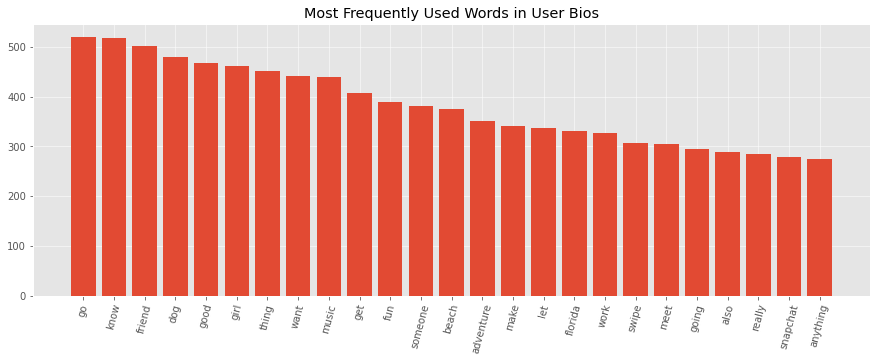

In [40]:
# Creating a set list that will only take in unique words
total_vocab = set()

# Iterating through the bios for each word
for bio in df['Bio']:
    total_vocab.update(bio)

# Printing out the number of unique words in all the bios combined
print("Number of unique words: ",len(total_vocab))

# Determining the most frequent words in user bios
words = []

# Adding all the words in each bio to a list
for bio in df['Bio']:
    words.extend(bio)

# Determining the use frequency of each word in all the bios
bio_freq = FreqDist(words)
bio_freq.most_common(104)    # 104 can be changed

# Plotting the most frequently used words
plt.style.use('ggplot')
plt.figure(figsize=(15,5))

plt.bar(*zip(*bio_freq.most_common(25)))
plt.xticks(rotation=75)
plt.title('Most Frequently Used Words in User Bios')
plt.show()

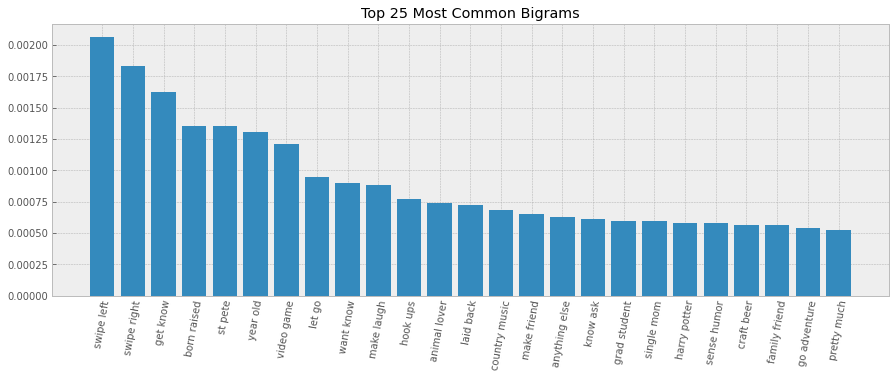

In [41]:
# Instantiating the score of each bigram
bigram_meas = BigramAssocMeasures()

# Finding and ranking the Bigrams in each bio
bio_finder = BigramCollocationFinder.from_words(words)

# Finding the frequency scores of each bigram 
bio_scored = bio_finder.score_ngrams(bigram_meas.raw_freq)

# Top 50 most common bigrams
bio_scored[:50]

# Creating a list of the bigrams
bg = list(map(lambda x: x[0][0] + ' ' + x[0][1], bio_scored[:50]))

# Creating a list of the frequency scores
bio_scores = list(map(lambda x: x[1], bio_scored[:50]))

# Combining both the scores and the bigrams
bigrams = list(zip(bg, bio_scores))

# Plotting the bigrams and their frequency scores
plt.style.use('bmh')
plt.figure(figsize=(15,5))

plt.bar(*zip(*bigrams[:25]))
plt.xticks(rotation=80)
plt.title('Top 25 Most Common Bigrams')
plt.show()

In [42]:
print(bio_list)

[['year', 'old', 'boy', 'ig'], ['real', 'la'], ['maybe', 'find', 'someone', 'travel', 'world', 'fun', 'weird', 'talk', 'dream', 'go', 'imagination', 'really', 'small', 'talk', 'sagittarius'], ['social', 'love', 'starting', 'morning', 'catching', 'making', 'music', 'florida', 'surfer', 'girl', 'moved', 'well', 'traveled', 'getting', 'lost', 'good', 'long', 'hike', 'think', 'keep'], [], ['wannabe', 'er', 'nurse', 'favorite', 'color', 'black', 'havent'], ['st', 'vincents', 'medical', 'center', 'riverside'], [], ['freshman', 'flagler', 'broke', 'busy', 'tbh', 'going', 'beach', 'attempting', 'yoga', 'concert', 'anything', 'artsyslightly', 'free', 'night', 'want', 'hang', 'fun', 'interesting', 'kill', 'relax'], ['alpha', 'femalesarcastic', 'assholewittygoofy', 'beerchicken', 'wing', 'pizza', 'kinda', 'girl', 'tattooskaraoke', 'queen', 'enjoy', 'huntin', 'fishin', 'always', 'anything', 'adventurous', 'never', 'burger', 'need', 'stop', 'total', 'game', 'woman', 'got', 'daythis', 'joke', 'would

In [43]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from gensim.models import Word2Vec 
from sklearn.manifold import TSNE
# build vocabulary and train model
w2vmodel= Word2Vec(
        bio_list,
        size=100,
        window=1,
        sg=0,
        min_count=0,
        workers=10,
        iter=20)

def model_dictionary(model):
  words = list(w2vmodel.wv.vocab)
  return words 

def get_embedding(word, model):
  if word in w2vmodel.wv.vocab:
    return w2vmodel.wv[word]
  else:
    return None

In [44]:
get_embedding("dog",w2vmodel)

array([ 0.6966544 , -0.84347314, -0.00761454, -0.55135   , -0.5006671 ,
        0.2590793 , -0.09936676, -0.09307659,  0.0014174 , -0.04035335,
       -0.38463312, -0.3094571 ,  0.34473148,  0.44145638, -0.02332845,
       -0.51948243,  0.00539962, -0.6689852 , -0.11425754, -0.04038382,
        0.23360044,  0.04220307, -0.70288503,  0.14908072, -0.01338525,
        0.08126663,  0.01705053, -0.2523753 ,  0.15185784, -0.00469647,
        0.34984693, -0.08683088,  0.01274068,  0.15092537,  0.07529338,
        1.1659405 ,  0.5251828 , -0.51233286, -0.128667  , -0.5362358 ,
        0.18569203, -0.02060279, -0.1601964 , -0.5639856 , -0.34277678,
        0.44287154,  0.5307123 ,  0.15109074,  0.17731602,  0.15207179,
       -0.81270504, -0.02511715,  0.25371933,  0.4043499 ,  0.8640866 ,
        0.06003184,  0.12689652, -0.55245566,  0.12699611,  0.24352299,
       -0.6148156 ,  0.06682081, -0.74623173, -0.51233035, -0.51564234,
       -0.48849705,  0.41771805,  0.234054  , -0.05284917, -0.03

In [45]:
# w2vmodel.wv.similarity(w1='music',w2='dog')


In [46]:
# w2vmodel.wv.most_similar(positive='dog')

In [47]:
def get_cluster_embeddings(keys):
  embedding_clusters = []
  word_clusters = []

  # find closest words and add them to cluster
  for word in keys:
    embeddings = []
    words = []
    if not word in w2vmodel.wv.vocab:
      print('The word ', word, 'is not in the dictionary')
      continue
    for similar_word, _ in w2vmodel.wv.most_similar(word, topn=10):
          words.append(similar_word)
          embeddings.append(w2vmodel.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

   # get embeddings for the words in clusers
  embedding_clusters = np.array(embedding_clusters)
  n, m, k = embedding_clusters.shape
  tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=3500, random_state=32)
  embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
  return embeddings_en_2d, word_clusters

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc="lower right")
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [48]:
# keys = ['animal', 'music', 'travel', 'sport']
# embeddings_en_2d, word_clusters = get_cluster_embeddings(keys)
# tsne_plot_similar_words('Similar words in Bios', keys, embeddings_en_2d, word_clusters, 0.7,
#                         'similar_words.png')

NameError: ignored

## **Doc2Vec** 

In [53]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# Normalize words
lemmatizer = WordNetLemmatizer()

# Tokenizing Function
def clear(text, tokenize = False):
  # Creating a library of stopwords
  stops = stopwords.words('english')+['love', 'like', 'im', 'dont', 'looking', 'new', 'friend', 'time', 'people', 'life']

  # Lowering the words
  text = text.lower()
  # Removing the punctuations
  text = re.sub(r'[^\w\s]',"", text)
  # Removing the number
  text = re.sub(r'\d+','',text)
  # Removing the emojis
  text = text.encode('ascii', 'ignore').decode('ascii')
  # Removing '\n' with a space
  text = text.replace('\n', ' ')
  # Replace double whitespace with signal whitespace and remove leading and trailing whitespcaes
  text = re.sub('\s+', ' ', text).strip()
  # Splitting on spaces between words
  text = text.split(' ')

  text = list(filter(None, text))

  # Lemmatizing the words and removing stop words
  
  text = [lemmatizer.lemmatize(i) for i in text if i not in stops]
  if tokenize == False:
    text =  ' '.join(text) 
  return text

In [54]:
df = pd.read_csv('/content/drive/Shareddrives/CIS519/tindetheus_datasets/TinderFullDataBase/user_database.csv')
df.drop(columns=['Unnamed: 0','Photos'], inplace=True)
df['Jobs'] = df['Jobs'].str.strip('[]').str.strip(' ')
df['Schools'] = df['Schools'].str.strip('[]').str.strip()
df = df.drop_duplicates()
df=df.replace(r'', np.nan, regex=True)
df = df.loc[df['Did I like?'].isna()==False,:]
df = df.loc[df['Name'].isna()==False,:]
df = df.loc[df['UserID'].isna()==False,:]
df.drop(columns=['Name'], inplace=True)
df.loc[df["Jobs"].isna() == False,"Jobs"] = 1
df.loc[df["Schools"].isna() == False,"Schools"] = 1
df.loc[df["Jobs"].isna() != False,"Jobs"] = 0
df.loc[df["Schools"].isna() != False,"Schools"] = 0
df = df.reset_index(drop= True)
df.loc[df['Bio'].isna() ==True, 'Bio'] = str('')
for i in range(len(df)):
  df['Bio'][i] = " ".join(clear(df['Bio'][i], tokenize = True))

bio_list = df['Bio'].tolist()
print(bio_list)

tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(bio_list)]

['chillll year old boy ig mlwbiatchh', 'real hasta la muerte', 'maybe find someone travel world fun weird talk dream go imagination really small talk sagittarius', 'whovian social historian love starting morning catching wave making music florida surfer girl moved glasgow well traveled getting lost good long hike think keep', '', 'wannabe er nurse favorite color black havent noticed ank', 'st vincents medical center riverside', '', 'freshman flagler broke busy tbh going beach attempting yoga concert anything artsyslightly pretentious free night want hang fun interesting kill relax', 'alpha femalesarcastic assholewittygoofy beerchicken wing pizza kinda girl tattooskaraoke queen enjoy huntin fishin always anything adventurous never krispy kreme doughnut burger need stop reevaluate total game changer woman got wooden implant daythis joke would funny punch line wooden tit sorry thats breast joke got', '', '', 'v katie year old', 'super know real add snapchat luckycharm_tee pretty funny sar

In [55]:
tagged_data

[TaggedDocument(words=['chillll', 'year', 'old', 'boy', 'ig', 'mlwbiatchh'], tags=['0']),
 TaggedDocument(words=['real', 'hasta', 'la', 'muerte'], tags=['1']),
 TaggedDocument(words=['maybe', 'find', 'someone', 'travel', 'world', 'fun', 'weird', 'talk', 'dream', 'go', 'imagination', 'really', 'small', 'talk', 'sagittarius'], tags=['2']),
 TaggedDocument(words=['whovian', 'social', 'historian', 'love', 'starting', 'morning', 'catching', 'wave', 'making', 'music', 'florida', 'surfer', 'girl', 'moved', 'glasgow', 'well', 'traveled', 'getting', 'lost', 'good', 'long', 'hike', 'think', 'keep'], tags=['3']),
 TaggedDocument(words=[], tags=['4']),
 TaggedDocument(words=['wannabe', 'er', 'nurse', 'favorite', 'color', 'black', 'havent', 'noticed', 'ank'], tags=['5']),
 TaggedDocument(words=['st', 'vincents', 'medical', 'center', 'riverside'], tags=['6']),
 TaggedDocument(words=[], tags=['7']),
 TaggedDocument(words=['freshman', 'flagler', 'broke', 'busy', 'tbh', 'going', 'beach', 'attempting', 

In [56]:
max_epochs = 20 # This can be changed; using 20 as a demo
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
Model Saved


In [57]:
from gensim.models.doc2vec import Doc2Vec

model= Doc2Vec.load("d2v.model")
#to find the vector of a document which is not in training data
test_data = word_tokenize("I love chatbots".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs['1'])

V1_infer [ 0.03369015 -0.13985626 -0.05024139 -0.14974582 -0.12473065  0.15095584
  0.08701774 -0.05956374  0.09362075  0.10036196 -0.05166693 -0.00396215
 -0.06745099  0.04319033  0.05157622 -0.08738934  0.14621319 -0.03671839
 -0.05156835  0.1548936 ]
[('784', 0.8843379020690918), ('2717', 0.865261435508728), ('4927', 0.8321059942245483), ('2111', 0.7861603498458862), ('2113', 0.7820401191711426), ('4341', 0.7754778861999512), ('1288', 0.7599204778671265), ('7708', 0.7596862316131592), ('5308', 0.7437870502471924), ('1735', 0.7421159744262695)]
[ 0.12843762 -0.57373154 -1.2480156  -0.53316367 -0.0164661   0.91772884
 -0.9232604   0.36129016 -0.33111924  2.0887468  -1.4733691   0.5129643
 -0.33883545  0.5718629   0.00847608  0.10017204  0.46410373  0.5750137
  0.80031604  0.68446803]


In [58]:
model.docvecs[3]

array([ 0.8068491 , -2.1586971 ,  1.4669306 , -2.547426  , -3.1737783 ,
        0.06379257, -0.8013052 ,  1.2393198 ,  2.0631053 ,  0.34505033,
        0.321807  , -1.5376319 , -0.9274387 , -0.12323833,  0.52013505,
        1.9471819 ,  0.8922595 ,  0.07385759, -0.08208707,  2.4794555 ],
      dtype=float32)

In [59]:
result = model.docvecs[0]
for i in range(1, len(model.docvecs)):
  result = np.vstack((result, model.docvecs[i]))

In [60]:
print(result)

[[ 0.4999899  -1.8557966  -0.0377662  ...  0.23845099  0.28016645
   0.9285191 ]
 [ 0.12843762 -0.57373154 -1.2480156  ...  0.5750137   0.80031604
   0.68446803]
 [ 0.6459414  -0.43678972 -2.168078   ...  3.0596435  -0.37427673
   1.5595543 ]
 ...
 [ 0.06810378  1.0870129  -0.86814135 ... -1.8521794  -0.26852316
   1.8643619 ]
 [ 0.5176468  -2.1879313  -0.6426249  ... -0.6755384  -0.077146
   0.8499275 ]
 [-0.10815457 -1.0154674  -0.4475447  ...  0.13655354  0.07236264
   1.525875  ]]


In [61]:
df_doc2vec = pd.DataFrame(result, columns = ['Column_A','Column_B','Column_C', 'Column_D','Column_E','Column_F', 'Column_G','Column_H','Column_I', 'Column_J','Column_K','Column_L','Column_M','Column_N','Column_O', 'Column_P','Column_Q','Column_R', 'Column_S','Column_T'])

In [62]:
df_doc2vec

,Column_A,Column_B,Column_C,Column_D,Column_E,Column_F,Column_G,Column_H,Column_I,Column_J,Column_K,Column_L,Column_M,Column_N,Column_O,Column_P,Column_Q,Column_R,Column_S,Column_T
0,0.499990,-1.855797,-0.037766,-1.668279,-1.166766,0.389939,0.191023,0.168174,-0.916029,0.952385,-0.652293,0.725584,-1.281961,0.591373,0.313523,-2.060024,0.395834,0.238451,0.280166,0.928519
1,0.128438,-0.573732,-1.248016,-0.533164,-0.016466,0.917729,-0.923260,0.361290,-0.331119,2.088747,-1.473369,0.512964,-0.338835,0.571863,0.008476,0.100172,0.464104,0.575014,0.800316,0.684468
2,0.645941,-0.436790,-2.168078,-1.588092,-1.618775,-1.149637,1.688950,0.042510,-0.933022,1.439139,-1.286577,-1.482290,-0.714082,-0.404970,1.041759,-1.072770,1.747950,3.059644,-0.374277,1.559554
3,0.806849,-2.158697,1.466931,-2.547426,-3.173778,0.063793,-0.801305,1.239320,2.063105,0.345050,0.321807,-1.537632,-0.927439,-0.123238,0.520135,1.947182,0.892259,0.073858,-0.082087,2.479455
4,0.010024,-0.012980,-0.002721,-0.006952,-0.010002,-0.015222,-0.010637,0.002715,-0.007321,-0.002715,-0.017171,0.010391,0.021870,0.022767,0.011415,-0.024136,-0.017049,0.006947,0.000893,0.007449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8472,-0.733804,-2.927253,-1.777333,-3.272882,0.810664,-0.640941,0.882857,1.230954,2.908211,0.883348,-4.815628,0.685580,-0.357515,1.033058,-1.191511,-0.289665,-0.301123,-0.650596,-2.309209,2.427847
8473,1.257143,0.262514,-3.031157,-3.001542,-1.934391,0.656251,-0.856432,0.644455,0.113158,1.076727,0.012613,0.922660,1.226009,2.008873,-0.661393,-0.093297,-0.242097,-0.584829,-0.229105,0.939061
8474,0.068104,1.087013,-0.868141,0.242062,-0.608332,2.057392,5.614893,1.079740,2.164410,1.643315,1.995772,-0.416272,-0.803025,0.610285,2.299836,-1.966498,0.163101,-1.852179,-0.268523,1.864362
8475,0.517647,-2.187931,-0.642625,0.698940,-2.192591,1.624775,-0.947263,1.034316,0.483268,-0.047126,-0.671125,2.590274,2.071337,0.987434,-0.065561,-1.674725,0.162385,-0.675538,-0.077146,0.849927


In [63]:
new_df = pd.concat([df, df_doc2vec], axis=1)

In [64]:
np.save('doc2vec.npy', new_df.to_numpy())

In [65]:
new_num_arr = np.load('doc2vec.npy', allow_pickle=True)

In [66]:
new_num_arr

array([['23', 'chillll year old boy ig mlwbiatchh', '90.12304', ...,
        0.23845098912715912, 0.2801664471626282, 0.9285191297531128],
       ['20', 'real hasta la muerte', '99.77908', ...,
        0.5750136971473694, 0.8003160357475281, 0.6844680309295654],
       ['20',
        'maybe find someone travel world fun weird talk dream go imagination really small talk sagittarius',
        '91.73238', ..., 3.059643507003784, -0.374276727437973,
        1.5595543384552002],
       ...,
       ['24',
        'scorpio american argentinean italian muscle car gym rat lift partner guy tattoo tattoo lol originally nyc bike riding volleyball movie buff true gentleman cook almost anything someone date hard ask actually look picture definitely overusing emojis lol crazy swipe left',
        '3.21868', ..., -1.8521794080734253, -0.2685231566429138,
        1.8643618822097778],
       ['31',
        'vegan adventurer attracted kindness intelligence critical thinking skill',
        '6.43736', ...